In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import torchvision
import torchvision.transforms as transforms


In [10]:
Batch_Size = 32

transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data',train=True, download =True,
                                      transform = transform)
trainLoader = torch.utils.data.DataLoader(trainset,batch_size=Batch_Size,
                                         shuffle=True,num_workers=0)
testset = torchvision.datasets.MNIST(root='./data',train=False,
                                    download=True,transform=transform)
testLoader = torch.utils.data.DataLoader(testset,batch_size=Batch_Size,
                                        shuffle=False,num_workers=0)

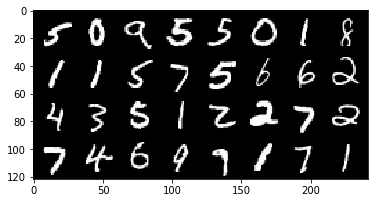

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
dataiter = iter(trainLoader)
images,labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [12]:
N_Steps = 28
N_Inputs = 28
N_Neurons = 150
N_Outputs = 10
N_Epochs =10


In [13]:
class ImageRNN(nn.Module):
    def __init__(self,batch_size,n_steps,n_inputs,n_neurons,n_outputs):
        super(ImageRNN,self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs,self.n_neurons)
        
        self.FC = nn.Linear(self.n_neurons,self.n_outputs)

    def init_hidden(self):
        return (torch.zeros(1,self.batch_size,self.n_neurons))
    
    def forward(self,X):
        X = X.permute(1,0,2)
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X,self.hidden)
        out = self.FC(self.hidden)
        
        return out.view(-1,self.n_outputs)
    

In [14]:
dataiter = iter(trainLoader)
images, labels = dataiter.next()
# model = ImageRNN(Batch_Size,N_Steps,N_Inputs,N_Neurons,N_Outputs)
# logits = model(images.view(-1,28,28))
# # print(logits[0:5])

In [15]:
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = ImageRNN(Batch_Size,N_Steps,N_Inputs,N_Neurons,N_Outputs)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

def get_accuracy(logit,target,batch_size):
    corrects = (torch.max(logit,1)[1].view(target.size()).data==target.data).sum()
    accuracy = 100.0* corrects/batch_size
    
    return accuracy.item()

In [16]:
for epoch in range(N_Epochs):
    train_running_loss = 0.0
    train_acc = 0.0
    
    model.train()
    for i,data in enumerate(trainLoader):
        optimizer.zero_grad()
        
        model.hidden = model.init_hidden()
        inputs, labels = data
        inputs = inputs.view(-1,28,28)
        outputs = model(inputs)
        
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs,labels,Batch_Size)
        
    model.eval()
    print("Epoch: %d | Loss: %.4f | Train_Accu: %.2f"
         %(epoch,train_running_loss/i, train_acc/i))

Epoch: 0 | Loss: 0.7059 | Train_Accu: 77.23
Epoch: 1 | Loss: 0.3112 | Train_Accu: 91.19
Epoch: 2 | Loss: 0.2300 | Train_Accu: 93.46
Epoch: 3 | Loss: 0.1935 | Train_Accu: 94.62
Epoch: 4 | Loss: 0.1788 | Train_Accu: 95.15
Epoch: 5 | Loss: 0.1640 | Train_Accu: 95.45
Epoch: 6 | Loss: 0.1659 | Train_Accu: 95.34
Epoch: 7 | Loss: 0.1560 | Train_Accu: 95.66
Epoch: 8 | Loss: 0.1534 | Train_Accu: 95.77
Epoch: 9 | Loss: 0.1482 | Train_Accu: 95.85


In [17]:
test_acc = 0.0
for i,data in enumerate(testLoader,0):
    inputs,labels = data
    inputs = inputs.view(-1,28,28)
    outputs = model(inputs)
    test_acc += get_accuracy(outputs,labels,Batch_Size)
print('Test Accuracy: %.2f'%(test_acc/i))

Test Accuracy: 95.87
